In [11]:
import pandas as pd
# 判断是否为闰年
def is_leap_year(year):
    return (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)

# 获取月份的天数
def days_in_month(year, month):
    if month in [1, 3, 5, 7, 8, 10, 12]:
        return 31
    elif month in [4, 6, 9, 11]:
        return 30
    elif month == 2:
        return 29 if is_leap_year(year) else 28
    return None

# 1. 读取Excel文件
file_path = r"A1.xlsx"
data = pd.read_excel(file_path)

# 2. 创建新特征

data['单价（元）'] = data["金额（元）"]/data['销量（箱）'] 
data['年份'] = data['月份'].astype(str).str[:4].astype(int)
data['月份_数字'] = data['月份'].astype(str).str[4:].astype(int)

# 春节日期映射表
spring_festival_dates = {
    2011: 2,
    2012: 1,
    2013: 2,
    2014: 1,
    2015: 2,
    2016: 2,
    2017: 1,
    2018: 2,
    2019: 2,
    2020: 1,
    2021: 2,
    2022: 2
}

data['累计销量'] = data['销量（箱）'].cumsum()
# 3. 将新特征添加到原始数据中并保存
output_file_path = r"A1_step1.xlsx"
data.to_excel(output_file_path, index=False)

print("新特征已添加到原始数据中，并保存到文件：", output_file_path)

新特征已添加到原始数据中，并保存到文件： A1_step1.xlsx


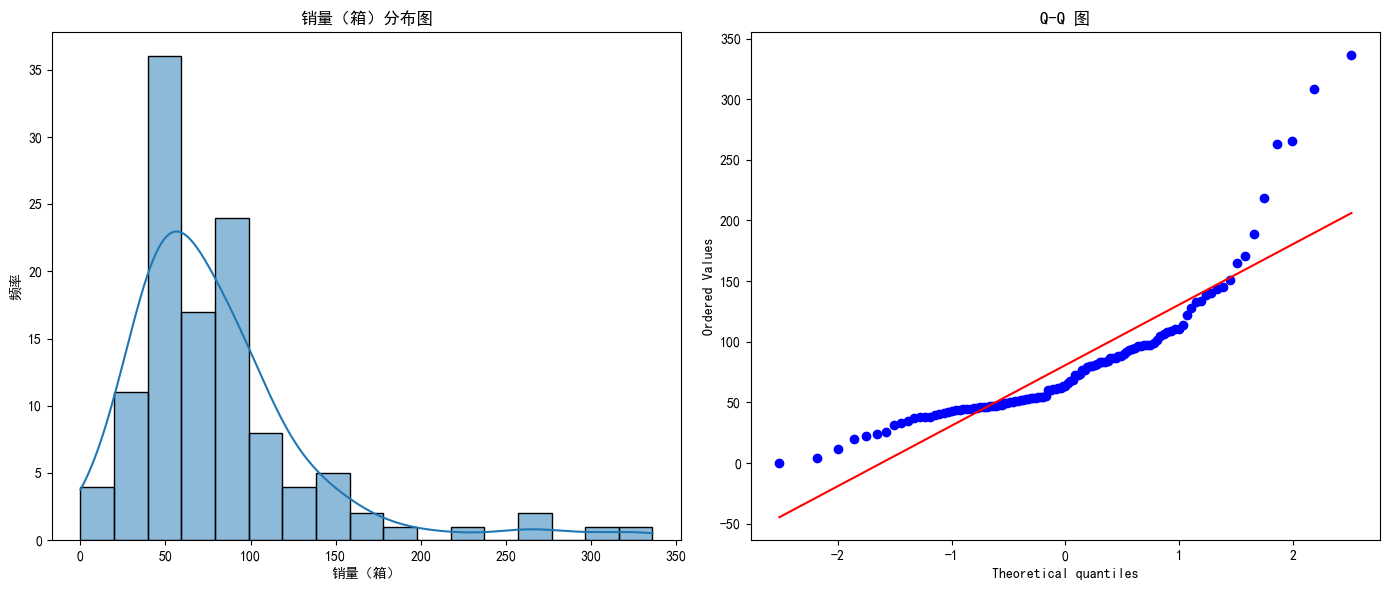

{'检验统计量': 71.6681325112497, 'p值': 2.738184836061163e-16}


In [12]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# 设置字体以显示中文
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 尝试读取Excel文件
try:
    # 文件路径
    file_path = r"A1.xlsx"
    # 读取数据
    data = pd.read_excel(file_path)
    
    # 检查销量（箱）列是否存在
    if '销量（箱）' in data.columns:
        # 提取销量（箱）列数据
        sales_data = data['销量（箱）']
        
        # 正态性检验
        k2, p = stats.normaltest(sales_data)
        
        # 准备输出结果
        normal_test_result = {
            '检验统计量': k2,
            'p值': p
        }
        
        # 创建画布
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # 绘制直方图和密度曲线
        sns.histplot(sales_data, kde=True, ax=ax1)
        ax1.set_title('销量（箱）分布图')
        ax1.set_xlabel('销量（箱）')
        ax1.set_ylabel('频率')
        
        # 绘制 Q-Q 图
        stats.probplot(sales_data, plot=ax2, fit=True)
        ax2.set_title('Q-Q 图')
        
        # 调整子图之间的间距
        plt.tight_layout()
        
        # 显示图表
        plt.show()
        
        # 返回正态性检验结果
        print(normal_test_result)
    else:
        "销量（箱）列在数据中不存在。"
except Exception as e:
    print(str(e))



In [13]:
import pandas as pd

# 定义文件路径
file_path = r"A1_step1.xlsx"
output_path = r"A1_step2.xlsx"

# 读取Excel文件
df = pd.read_excel(file_path)

# 计算第1百分位和第99百分位
lower_bound = df['销量（箱）'].quantile(0.01)
upper_bound = df['销量（箱）'].quantile(0.99)
print(lower_bound, upper_bound)
# 找出异常值
outliers = df[((df['销量（箱）'] < lower_bound) | (df['销量（箱）'] > upper_bound)) & (df['月份'] %100 !=1)]

# 输出异常值
print("被删除的数据:")
print(outliers)

# 移除异常值
cleaned_df = df[((df['销量（箱）'] >= lower_bound) & (df['销量（箱）'] <= upper_bound)) | (df['月份'] %100 ==1)]

# 写入处理后的数据到新的Excel文件
cleaned_df.to_excel(output_path, index=False)

5.497599999999999 301.40496000000013
被删除的数据:
        月份      样品代码     名称  销量（箱）    金额（元）    单价（元）    年份  月份_数字      累计销量
35  201312  43010103  A(绿和)   0.04    720.0  18000.0  2013     12  4229.632
95  201812  43010103  A(绿和)   4.32  82425.6  19080.0  2018     12  8196.964


In [21]:
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def read_data(file_path):
    data = pd.read_excel(file_path)
    return data

def find_missing_months(data):
    months = pd.date_range(start='2011-01', end='2019-12', freq='MS').strftime('%Y%m')
    existing_months = data['月份'].astype(str).tolist()
    missing_months = [month for month in months if month not in existing_months]
    return missing_months

def update_cumulative_sales(data):
    data['月份'] = data['月份'].astype(int)
    data = data.sort_values(by=['样品代码', '月份'])
    data['累计销量'] = data.groupby('样品代码')['销量（箱）'].cumsum()
    return data

def save_to_excel(data, output_path):
    data.to_excel(output_path, index=False)

def interpolate_polynomial_regression(data, missing_months, degree=3):
    """
    使用多项式回归插值补全缺失的销量数据，并输出插值数据。
    :param data: 原始数据的DataFrame
    :param missing_months: 缺失的月份列表
    :param degree: 多项式的度数
    :return: 填补缺失值后的DataFrame
    """
    samples = data['样品代码'].unique()
    
    for sample in samples:
        sample_data = data[data['样品代码'] == sample]
        sample_data['月份'] = sample_data['月份'].astype(int)
        sample_data = sample_data.sort_values(by='月份')
        x = sample_data['月份'].values.reshape(-1, 1)
        y = sample_data['销量（箱）'].values
        
        # 多项式回归
        polynomial_features = PolynomialFeatures(degree=degree)
        linear_regression = LinearRegression()
        model = make_pipeline(polynomial_features, linear_regression)
        model.fit(x, y)
        
        x_new = np.array([int(month) for month in missing_months]).reshape(-1, 1)
        y_new = model.predict(x_new)
        
        for month, value in zip(missing_months, y_new):
            print(f"样品代码: {sample}, 月份: {month}, 插值销量（箱）: {value:.2f}")
        
        new_rows = pd.DataFrame({
            '月份': missing_months,
            '样品代码': sample,
            '名称': sample_data['名称'].iloc[0],
            '销量（箱）': y_new,
            '金额（元）': y_new*np.where(
                np.array([int(month) for month in missing_months]) < 201505,
                18000,
                19080
            ),
            '单价（元）': np.where(
                np.array([int(month) for month in missing_months]) < 201505,
                18000,
                19080
            ),
            '年份': [int(month[:4]) for month in missing_months],
            '月份_数字': [int(month[4:]) for month in missing_months],
            '累计销量': np.nan
        })
        
        data = pd.concat([data, new_rows], ignore_index=True)
    
    return data

# 主流程
file_path = r"A1_step2.xlsx"
output_path = r"A1_step3.xlsx"

data = read_data(file_path)
missing_months = find_missing_months(data)
data = interpolate_polynomial_regression(data, missing_months)
data = update_cumulative_sales(data)
save_to_excel(data, output_path)


样品代码: 43010103, 月份: 201312, 插值销量（箱）: 101.57
样品代码: 43010103, 月份: 201812, 插值销量（箱）: 55.57


C:\Users\14400\AppData\Local\Temp\ipykernel_13888\3613800005.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['month_index'] = range(1, len(filtered_data) + 1)


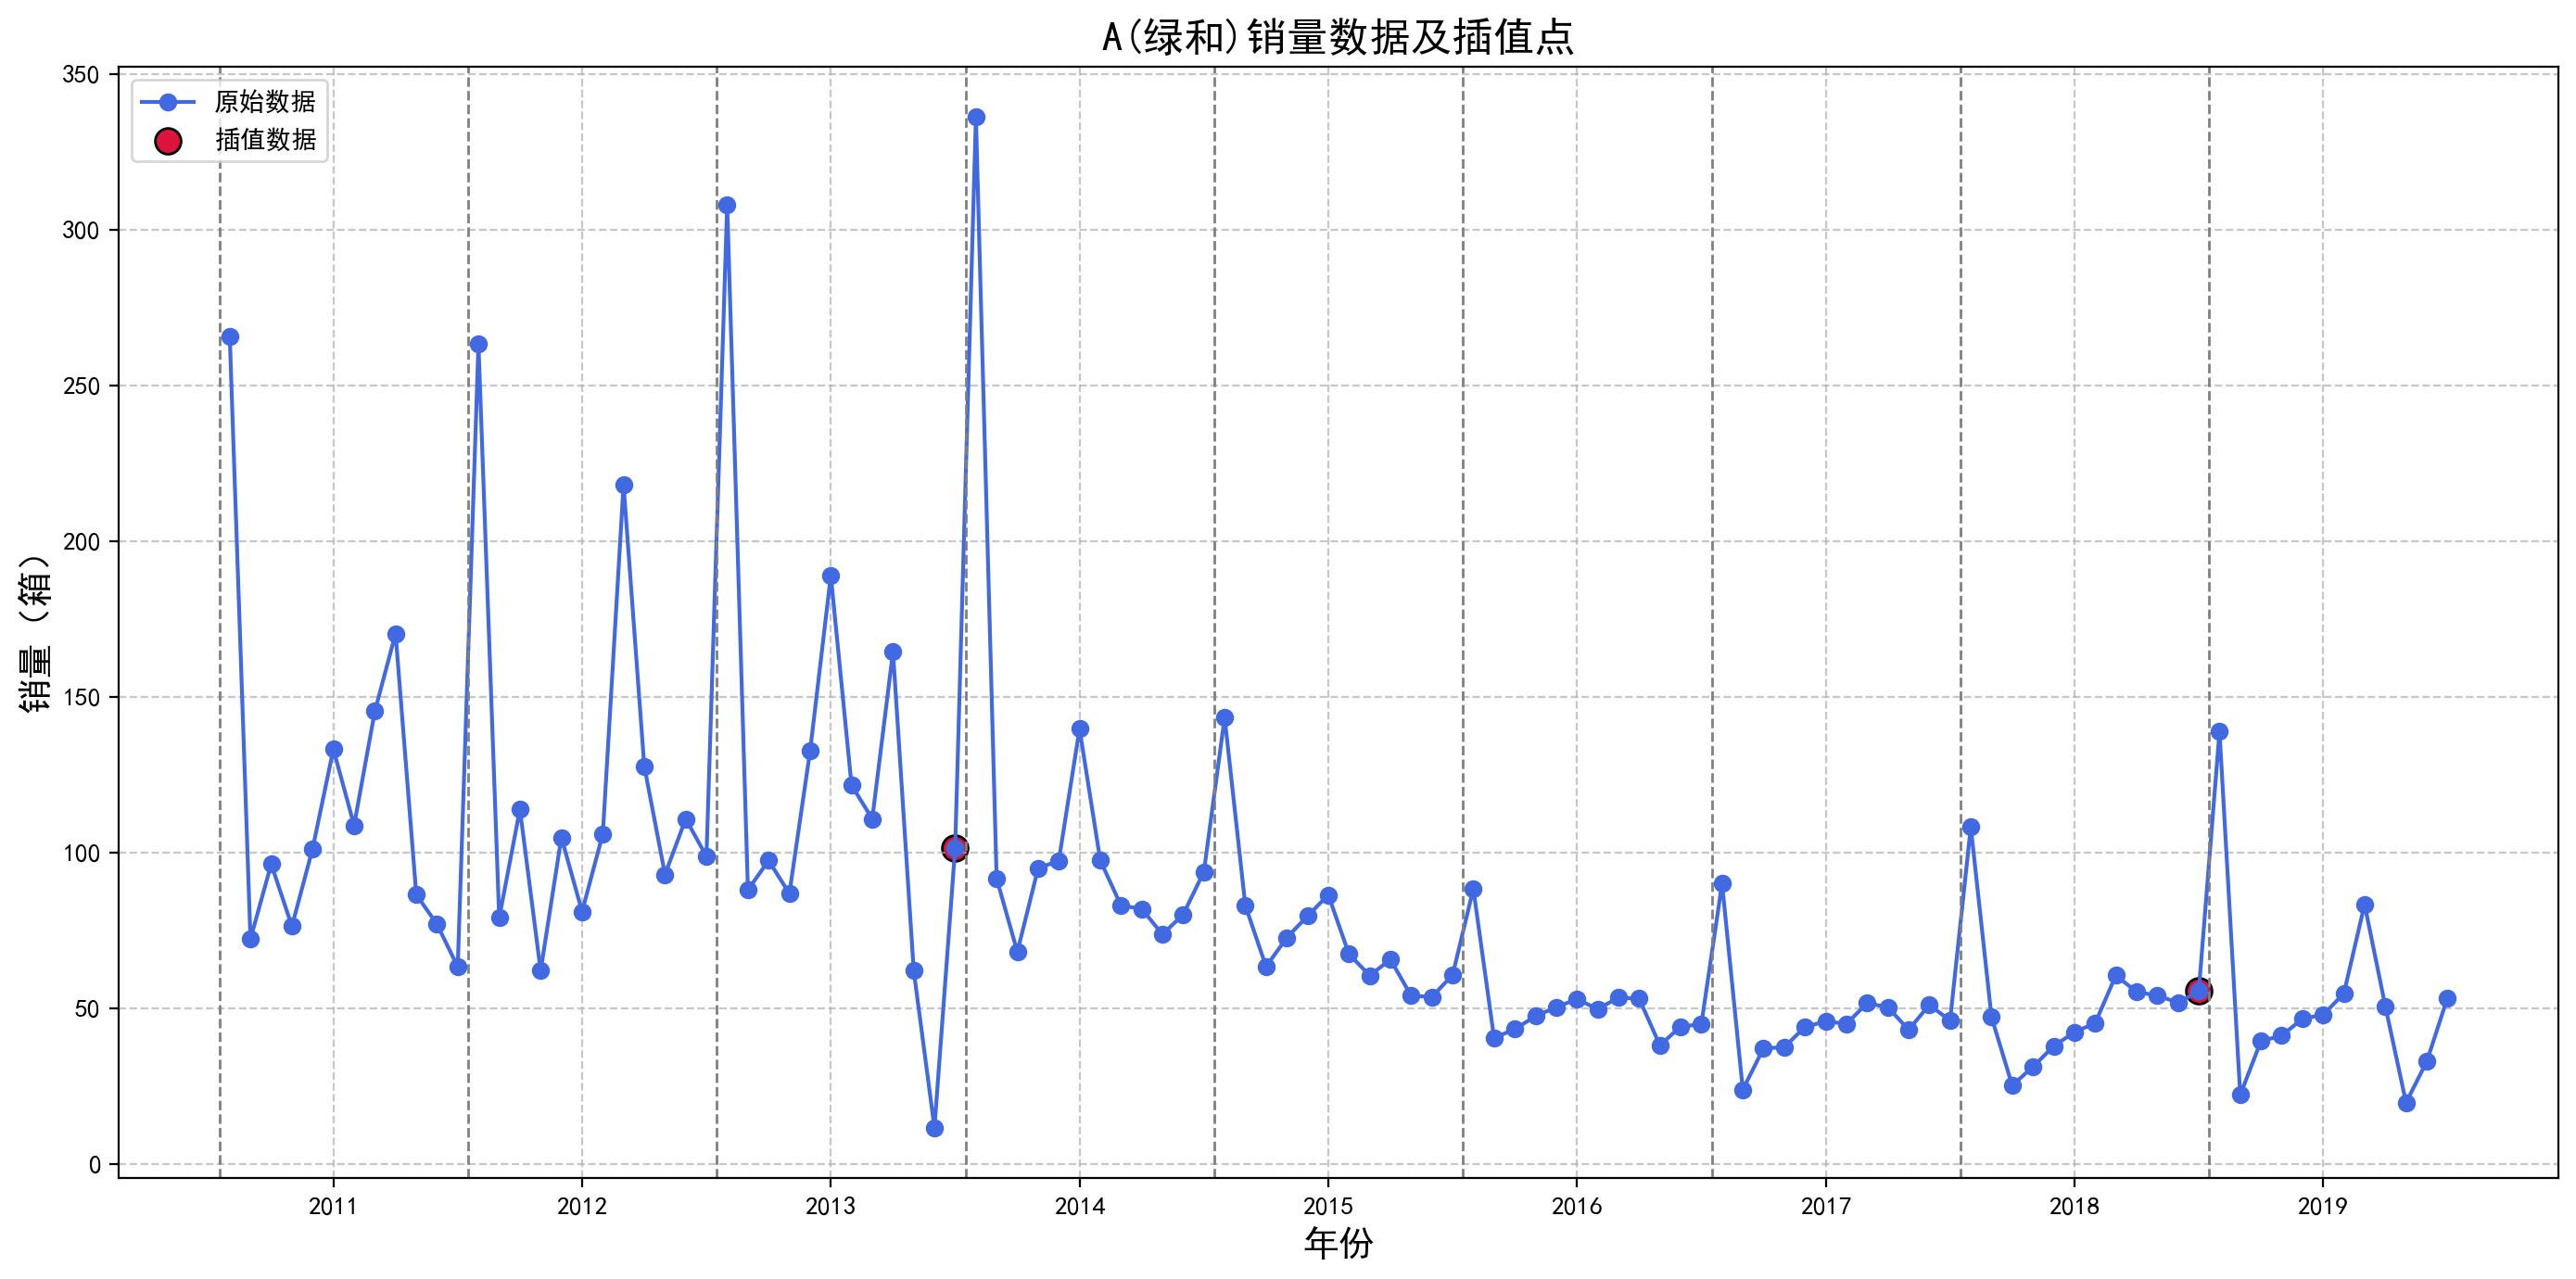

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取Excel文件
file_path = r"A1_step3.xlsx"
data = pd.read_excel(file_path)

# 插值数据的月份
interpolated_months = [201312, 201812]

# 创建一个新列来标记是否为插值数据
data['is_interpolated'] = data['月份'].isin(interpolated_months)

# 筛选201101到201912的月份数据
filtered_data = data[(data['月份'] >= 201101) & (data['月份'] <= 201912)]

# 将月份转换为连续数值
filtered_data['month_index'] = range(1, len(filtered_data) + 1)

# 筛选出月份末尾为06的记录
june_data = filtered_data[filtered_data['月份'] % 100 == 6].copy()

# 为这些月份生成对应的年份标签
june_data.loc[:, 'year_label'] = (june_data['月份'] // 100).astype(str)

# 创建图形和轴
plt.figure(figsize=(14, 7),dpi=200)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False

# 绘制所有数据的折线图
plt.plot(filtered_data['month_index'], filtered_data['销量（箱）'], 
         label='原始数据', color='royalblue', linestyle='-', marker='o', markersize=6)

# 标红插值数据点
interpolated_data = filtered_data[filtered_data['is_interpolated']]
plt.scatter(interpolated_data['month_index'], interpolated_data['销量（箱）'], 
            color='crimson', label='插值数据', edgecolor='black', s=100)

# 添加竖线分隔年份
years = range(2011, 2020)
for year in years:
    start_index = filtered_data[filtered_data['月份'] == year * 100 + 1]['month_index'].values[0]
    plt.axvline(x=start_index - 0.5, color='gray', linestyle='--', linewidth=1)

# 添加x轴刻度标签，只显示月份末尾为06的
plt.xticks(june_data['month_index'], june_data['year_label'], rotation=0, fontsize=10)

# 添加图例
plt.legend(loc='upper left')

# 添加标题和标签
plt.title('A(绿和)销量数据及插值点', fontsize=16, fontweight='bold')
plt.xlabel('年份', fontsize=14)
plt.ylabel('销量（箱）', fontsize=14)

# 添加网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()
plt.show()


In [27]:
import pandas as pd
# 判断是否为闰年
def is_leap_year(year):
    return (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)

# 获取月份的天数
def days_in_month(year, month):
    if month in [1, 3, 5, 7, 8, 10, 12]:
        return 31
    elif month in [4, 6, 9, 11]:
        return 30
    elif month == 2:
        return 29 if is_leap_year(year) else 28
    return None

# 1. 读取Excel文件
file_path = r"A1_step3.xlsx"
data = pd.read_excel(file_path)

# 2. 创建新特征
# 2.1 分解日期信息
data['年份'] = data['月份'].astype(str).str[:4].astype(int)
data['月份_数字'] = data['月份'].astype(str).str[4:].astype(int)

# 春节日期映射表
spring_festival_dates = {
    2011: 2,
    2012: 1,
    2013: 2,
    2014: 1,
    2015: 2,
    2016: 2,
    2017: 1,
    2018: 2,
    2019: 2,
    2020: 1,
    2021: 2,
    2022: 2
}

# 判断是否为春节所在月
data['是否为春节所在月'] = data.apply(lambda row: 1 if row['月份_数字'] == spring_festival_dates.get(row['年份'], 0) else 0, axis=1)

# 计算每个月的天数
data['月份的天数'] = data.apply(lambda row: days_in_month(row['年份'], row['月份_数字']), axis=1)

# 计算该月平均每天销量（箱）
data['该月平均每天销量（箱）'] = data['销量（箱）'] / data['月份的天数']

# 计算该月平均每天金额（元）
data['该月平均每天金额（元）'] = data['金额（元）'] / data['月份的天数']

# 计算销量月增长量和月增长率
data['销量月增长量'] = data['销量（箱）'].diff()
data['销量月增长率'] = data['销量月增长量'] / data['销量（箱）'].shift(1)

# 计算销售金额月增长量和月增长率
data['销售金额月增长量'] = data['金额（元）'].diff()
data['销售金额月增长率'] = data['销售金额月增长量'] / data['金额（元）'].shift(1)

# 计算销量月环比增长率
data['销量月环比增长率'] = data.apply(lambda row: (row['销量（箱）'] - data[(data['年份'] == row['年份'] - 1) & (data['月份_数字'] == row['月份_数字'])]['销量（箱）'].values[0])
                                            / data[(data['年份'] == row['年份'] - 1) & (data['月份_数字'] == row['月份_数字'])]['销量（箱）'].values[0]
                                            if not data[(data['年份'] == row['年份'] - 1) & (data['月份_数字'] == row['月份_数字'])].empty else None, axis=1)

# 计算销售金额月环比增长率
data['销售金额月环比增长率'] = data.apply(lambda row: (row['金额（元）'] - data[(data['年份'] == row['年份'] - 1) & (data['月份_数字'] == row['月份_数字'])]['金额（元）'].values[0])
                                            / data[(data['年份'] == row['年份'] - 1) & (data['月份_数字'] == row['月份_数字'])]['金额（元）'].values[0]
                                            if not data[(data['年份'] == row['年份'] - 1) & (data['月份_数字'] == row['月份_数字'])].empty else None, axis=1)

# 2.3 计算累计特征
data['累计销量'] = data['销量（箱）'].cumsum()
data['累计销售金额'] = data['金额（元）'].cumsum()
data['年累计销量'] = data.groupby('年份')['销量（箱）'].cumsum()
data['年累计销售金额'] = data.groupby('年份')['金额（元）'].cumsum()

# 3. 将新特征添加到原始数据中并保存
output_file_path = r"A1_Feature.xlsx"
data.to_excel(output_file_path, index=False)

print("新特征已添加到原始数据中，并保存到文件：", output_file_path)

新特征已添加到原始数据中，并保存到文件： A1_Feature.xlsx
